In [1]:
 !pip install transformers

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
pip install openpyxl

     |████████████████████████████████| 242 kB 900 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx


In [5]:
df=pd.read_excel('/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [6]:
pip install ktrain

     |████████████████████████████████| 25.3 MB 890 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 22.3 MB 53.6 MB/s            
     |████████████████████████████████| 981 kB 42.6 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 263 kB 51.6 MB/s            
     |████████████████████████████████| 2.8 MB 52.1 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 468 kB 55.9 MB/s            
     |████████████████████████████████| 3.3 MB 53.7 MB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for ktrain: filename=ktrain-0.30.0-py3-none-any.wh

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [8]:
import ktrain
from ktrain import text

In [9]:
df_filtered = df[df['Label'] > 0]
df=df_filtered

In [10]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 Name: Label, dtype: int64,
 12119)

In [11]:
def Label(label):
    if(label==1):
        return 'positive'
    elif(label==2):
        return 'negative'
df['Sentiment'] = df['Label'].apply(Label)
df.Sentiment.value_counts(), len(df)

(positive    6410
 negative    5709
 Name: Sentiment, dtype: int64,
 12119)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
encoded_labels = le.transform(df['Label'])
labels = np.array(encoded_labels) # Converting into numpy array
class_names =le.classes_
print(class_names)

In [12]:
df.Sentiment.value_counts(), len(df)

(positive    6410
 negative    5709
 Name: Sentiment, dtype: int64,
 12119)

In [13]:
train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Token'].tolist()
y_train=train['Sentiment'].tolist()
x_validation=validation['Token'].tolist()
y_validation=validation['Sentiment'].tolist()
x_test=test['Token'].tolist()
y_test=test['Sentiment'].tolist()

In [14]:
x_train= np.array(x_train)
x_validation= np.array(x_validation)
x_test= np.array(x_test)


In [15]:
categories = ['positive','negative']

In [16]:
model_name = 'csebuetnlp/banglabert'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

Downloading:   0%|          | 0.00/586 [00:00<?, ?B/s]

In [17]:
train = trans.preprocess_train(x_train,y_train)
valid = trans.preprocess_test(x_validation,y_validation)

preprocessing train...
language: bn
train sequence lengths:
	mean : 17
	95percentile : 38
	99percentile : 48


/opt/conda/lib/python3.7/site-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Downloading:   0%|          | 0.00/119 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 17
	95percentile : 38
	99percentile : 48


In [18]:
model = trans.get_classifier()

404 Client Error: Not Found for url: https://huggingface.co/csebuetnlp/banglabert/resolve/main/tf_model.h5
/opt/conda/lib/python3.7/site-packages/ktrain/text/preprocessor.py:1070: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [19]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [20]:
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
weight={i:class_weight[i] for i in range(2)}

In [21]:
learner.fit_onecycle(2e-5,10,class_weight=weight) 



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
808/808 [==============================] - 124s 127ms/step - loss: 0.5447 - accuracy: 0.7269 - val_loss: 0.4355 - val_accuracy: 0.8135
Epoch 2/10
808/808 [==============================] - 100s 124ms/step - loss: 0.4096 - accuracy: 0.8250 - val_loss: 0.3658 - val_accuracy: 0.8358
Epoch 3/10
808/808 [==============================] - 99s 123ms/step - loss: 0.3346 - accuracy: 0.8599 - val_loss: 0.3419 - val_accuracy: 0.8540
Epoch 4/10
808/808 [==============================] - 99s 123ms/step - loss: 0.2573 - accuracy: 0.9016 - val_loss: 0.3615 - val_accuracy: 0.8573
Epoch 5/10
808/808 [==============================] - 100s 124ms/step - loss: 0.2025 - accuracy: 0.9239 - val_loss: 0.3866 - val_accuracy: 0.8647
Epoch 6/10
808/808 [==============================] - 100s 123ms/step - loss: 0.1432 - accuracy: 0.9483 - val_loss: 0.4737 - val_accuracy: 0.8622
Epoch 7/10
808/808 [==============================] - 99s 122ms

In [22]:
learner.validate(class_names=categories)

              precision    recall  f1-score   support

    positive       0.85      0.89      0.87       578
    negative       0.90      0.86      0.88       634

    accuracy                           0.87      1212
   macro avg       0.87      0.87      0.87      1212
weighted avg       0.87      0.87      0.87      1212



array([[515,  63],
       [ 90, 544]])

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [24]:
y_pred = predictor.predict(x_test)
print(y_pred)

['negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'ne

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.83      0.86      0.85       554
    positive       0.88      0.86      0.87       658

    accuracy                           0.86      1212
   macro avg       0.86      0.86      0.86      1212
weighted avg       0.86      0.86      0.86      1212



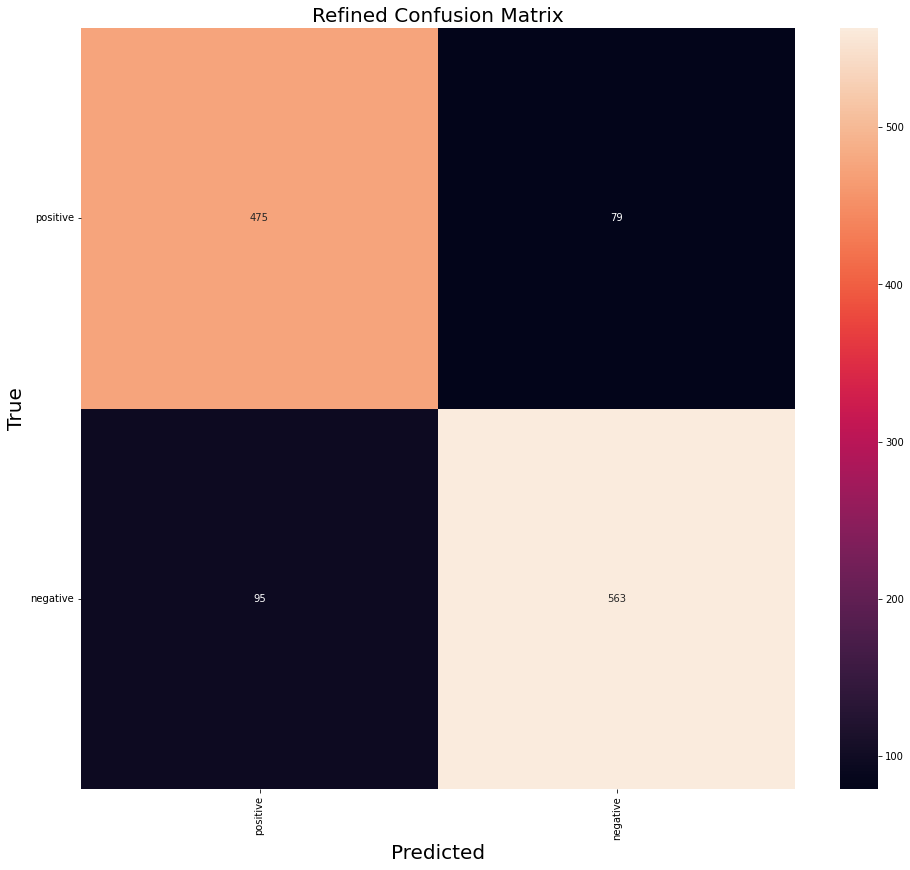

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 2
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()
